In [1]:
import numpy as np
import pynbody
import matplotlib.pyplot as plt
import matplotlib as mpl
import pynbody.plot as pp
import pickle
import pandas as pd
import pynbody.plot.sph as sph

In [2]:
from Time import *

In [3]:
%matplotlib inline
#mpl.rcParams['font.monospace'] = 'Terminal'
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

In [ ]:
2: 2,  116.08, .003584
3: 4,  78.68, .002816
5: 4, 91.30, .003328
6: 5,  80.29, .003328
9: 9, 49.10, .002688
10: 10, 86.53, .004096
11: 10,  49.25, .002304
13: 11,   40.01, .002304
14: 12,  56.29, .003712 
21: 17,   48.12, .003584
27: 14,  38.71,  .001920
28: 12,  21.30, .001920
32: 27, 47.00, .003584
36: 26, 41.33, .003072
37: 23,  28.86, .002688
41: 40,  55.76, .003968
45: 19,  24.70, .002176
48: 32,  32.34, .003584
61: 42, 28.56, .002688
68: 21, 15.33, .002432
80: 21, 18.71, .001920
96: 54, 19.58, .002688
127: 37, 22.75, .003195
128: 100, 17.74, .002816
136: 136, 21.39, .003968
163: 87,  15.71, .001280
212: 57,  13.69, .001740
265: 136,  26.12, .002048
278: 33,  26.15, .002048
283: 36, 28.08, .002432
329: 79, 10.48, .001269
386: 119,  16.11, .001536
442: 55, 14.69, .003456
678: 502, 9.47, .001740

In [5]:
def deviation1(nums): 
    nums = [2, 4, 4, 5, 9, 10, 10, 11, 12, 17, 14, 12, 27, 26, 23, 40, 19, 32, 42, 21, 21, 54, 37, 100, 136, 87, 57, 136, 33, 36, 79, 119, 55, 502]
    timesteps = ['.003584','.002816', '.003328', '.003328', '.002688','.004096', '.002304','.003712', '.003584', '.001920', '.001920','.003584', '.003072','.002688', '.003968', '.002176', '.003584','.002688', '.002432','.001920', '.002688', '.003195', '.002816','.003968', '.001280','.001740', '.002048', '.002432', '.001269','.001536', '.003456', '.001740']
    rvirs = [116.08, 78.68, 91.30, 80.29, 49.10, 86.53, 49.25, 40.01, 56.29, 48.12, 38.71, 21.30, 47.00, 41.33, 28.86, 55.76, 24.70, 32.34, 28.56, 15.33, 18.71, 19.58, 22.75, 17.74, 21.39, 15.71, 13.69, 26.12, 26.15, 28.08, 10.48, 16.11, 14.69, 9.47]
    h_mass1 = np.zeros(len(nums))
    STD1 = np.zeros(len(nums))
    ave_theta1 = np.zeros(len(nums))
    i = 0
    for num, timestep, rvir in zip(nums, timesteps, rvirs):
        print(num,timestep)
        sim_1 ='/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots/h148.cosmo50PLK.3072g3HbwK1BH' + timestep
        sim = pynbody.load(sim_1)
        h = sim.halos()
        sim.physical_units()
# ###Loads in halo
        halo_info = sim.halos(dummy=True)
        halo = h.load_copy(num)
        halo.physical_units()
        if len(halo.gas)==0:
            print("no gas")
            continue
        pynbody.analysis.halo.center(halo)
        h_mass1[i] = halo_info[num].properties['mass']
#         ###defines sphere on outer edge of halo
        inner_sphere = pynbody.filt.Sphere(str(.9*rvir) + ' kpc', [0,0,0])
        outer_sphere = pynbody.filt.Sphere(str(rvir) + ' kpc', [0,0,0])
        shell_part = sim[outer_sphere & ~inner_sphere].gas
        if len(shell_part)==0:
            print("no outer gas")
            continue
#         ###defines sphere surrounding halo
        inner_sphere_wind = pynbody.filt.Sphere(str(rvir) + ' kpc', [0,0,0])
        outer_sphere_wind = pynbody.filt.Sphere(str(3*rvir) + ' kpc', [0,0,0])
        shell_part_wind = sim[outer_sphere_wind & ~inner_sphere_wind].gas
        if len(shell_part_wind)==0:
            print("no wind")
            continue
###Creates cutoff value for vel of gas wind
        windv = (np.sum((shell_part_wind['vel']**2), axis=1))**.5
        vmin = 0.5*halo_info[num].properties['v_esc']
        Wind_mass = np.sum(shell_part_wind['mass'])        
        Wvel = np.array(shell_part_wind['vel'])[windv > vmin]
        Wymass = np.array(shell_part_wind['mass'])[windv > vmin]
        windyvec = np.mean(np.array(Wymass)[np.newaxis].T * Wvel,axis=0)/Wind_mass        
###Find Vel of gas inside the halo and creates array
        velocity = shell_part['vel'].in_units('kpc yr**-1')
        r = shell_part['pos'].in_units('kpc')
        vr = np.sum((velocity*r), axis=1)
        Vout = []
        for x in range(len(vr)):
            if vr[x] > 0:
                vel = list(velocity[x])
                Vout.append(vel)        
    ###takes the magnitude of the gas velocity vectors
        avecs = np.array(Vout)
        amags = (np.sum((avecs**2), axis=1))**.5
        bvec = windyvec
        bmag = (np.sum(bvec**2)**.5)
    ###Finds angle between avec and bvec
        Theta = []
        for avec,amag in zip(avecs,amags):
            adotb = np.sum((avec*bvec))
            ab = amag*bmag
            theta = np.arccos(adotb/ab)
            Theta = np.append(Theta, theta)
        STD1[i] = np.std(Theta)
        ave_theta1[i] = np.mean(Theta)
        i = i + 1
    return h_mass1, ave_theta1, STD1

In [6]:
h_mass1, ave_theta1, STD1 = deviation1(1)

2 .003584
4 .002816
4 .003328
5 .003328
9 .002688
no gas
10 .004096
10 .002304
11 .003712
12 .003584
17 .001920
14 .001920
12 .003584
27 .003072
26 .002688
23 .003968
40 .002176
19 .003584
32 .002688
42 .002432
21 .001920
21 .002688
54 .003195
no gas
37 .002816
100 .003968
no gas
136 .001280
no gas
87 .001740
57 .002048
136 .002432
no gas
33 .001269
36 .001536
79 .003456
no gas
119 .001740


In [ ]:
11: 7, 45.48, .003744
31: 14, 29.37, .003195
33: 17,  25.42, .002496
40: 27,  28.19, .003552
133: 37, 18.84, .001440
137: 24, 8.34, .001152

In [28]:
def deviation4(nums): 
    nums = [7, 14, 17, 27, 37, 24]
    timesteps = ['.003744','.003195', '.002496', '.003552', '.001440','.001152']
    rvirs = [45.48, 29.37, 25.42, 28.19, 18.84, 8.34]
    h_mass4 = np.zeros(len(nums))
    STD4 = np.zeros(len(nums))
    ave_theta4 = np.zeros(len(nums))
    i = 0
    for num, timestep, rvir in zip(nums, timesteps, rvirs):
        print(num,timestep)
        sim_4 ='/home/christenc/Data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots/h329.cosmo50PLK.3072gst5HbwK1BH' + timestep
        sim = pynbody.load(sim_4)
        h = sim.halos()
        sim.physical_units()
# ###Loads in halo
        halo_info = sim.halos(dummy=True)
        halo = h.load_copy(num)
        halo.physical_units()
        if len(halo.gas)==0:
            print("no gas")
            continue
        pynbody.analysis.halo.center(halo)
        h_mass4[i] = halo_info[num].properties['mass']
#         ###defines sphere on outer edge of halo
        inner_sphere = pynbody.filt.Sphere(str(.9*rvir) + ' kpc', [0,0,0])
        outer_sphere = pynbody.filt.Sphere(str(rvir) + ' kpc', [0,0,0])
        shell_part = halo[outer_sphere & ~inner_sphere].gas
        if len(shell_part)==0:
            print("no outer gas")
            continue
#         ###defines sphere surrounding halo
        inner_sphere_wind = pynbody.filt.Sphere(str(rvir) + ' kpc', [0,0,0])
        outer_sphere_wind = pynbody.filt.Sphere(str(3*rvir) + ' kpc', [0,0,0])
        shell_part_wind = sim[outer_sphere_wind & ~inner_sphere_wind].gas
        if len(shell_part_wind)==0:
            print("no wind")
            continue
###Creates cutoff value for vel of gas wind
        windv = (np.sum((shell_part_wind['vel']**2), axis=1))**.5
        vmin = 0.5*halo_info[num].properties['v_esc']
        Wind_mass = np.sum(shell_part_wind['mass'])        
        Wvel = np.array(shell_part_wind['vel'])[windv > vmin]
        Wymass = np.array(shell_part_wind['mass'])[windv > vmin]
        windyvec = np.mean(np.array(Wymass)[np.newaxis].T * Wvel,axis=0)/Wind_mass        
###Find Vel of gas inside the halo and creates array
        velocity = shell_part['vel'].in_units('kpc yr**-1')
        r = shell_part['pos'].in_units('kpc')
        vr = np.sum((velocity*r), axis=1)
        Vout = []
        for x in range(len(vr)):
            if vr[x] > 0:
                vel = list(velocity[x])
                Vout.append(vel)        
    ###takes the magnitude of the gas velocity vectors
        avecs = np.array(Vout)
        amags = (np.sum((avecs**2), axis=1))**.5
        bvec = windyvec
        bmag = (np.sum(bvec**2)**.5)
    ###Finds angle between avec and bvec
        Theta = []
        for avec,amag in zip(avecs,amags):
            adotb = np.sum((avec*bvec))
            ab = amag*bmag
            theta = np.arccos(adotb/ab)
            Theta = np.append(Theta, theta)
        STD4[i] = np.std(Theta)
        ave_theta4[i] = np.mean(Theta)
        i = i + 1
    return h_mass4, ave_theta4, STD4

In [29]:
h_mass4, ave_theta4, STD4 = deviation4(1)

7 .003744
no gas
14 .003195
no wind
17 .002496
no wind
27 .003552
no gas
37 .001440
no gas
24 .001152
no wind


In [ ]:
10: 6,  49.83, .001632
12: 5, 27.66, .001728
24: 19, 39.24, .002400
30: 17, 18.05, .001536
40: 41, 49.70, .003648
41: 19, 31.87, .003360
71: 57, 23.20, .002496
78: 65, 54.30, .003168
80: 14, 24.52, .002554
86: 46, 19.93, .003072
223: 47, 18.78, .003552
439: 78,  6.85, .001248

In [30]:
def deviation3(nums): 
    nums = [6, 5, 19, 17, 41, 19, 57, 65, 14, 46]
    timesteps = ['.001632','.001728', '.002400', '.001536', '.003648','.003360', '.002496', '.003168', '.002554', '.003072', '003552', '.001248']
    rvirs = [49.83, 27.66, 39.24, 18.05, 49.70, 31.87, 23.20, 54.30, 24.52, 19.93, 18.78, 6.85]
    h_mass3 = np.zeros(len(nums))
    STD3 = np.zeros(len(nums))
    ave_theta3 = np.zeros(len(nums))
    i = 0
    for num, timestep, rvir in zip(nums, timesteps, rvirs):
        print(num,timestep)
        sim_3 ='/home/christenc/Data/Sims/h242.cosmo50PLK.3072g/h242.cosmo50PLK.3072gst5HbwK1BH/snapshots/h242.cosmo50PLK.3072gst5HbwK1BH' + timestep
        sim = pynbody.load(sim_3)
        h = sim.halos()
        sim.physical_units()
# ###Loads in halo
        halo_info = sim.halos(dummy=True)
        halo = h.load_copy(num)
        halo.physical_units()
        if len(halo.gas)==0:
            print("no gas")
            continue
        pynbody.analysis.halo.center(halo)
        h_mass3[i] = halo_info[num].properties['mass']
#         ###defines sphere on outer edge of halo
        inner_sphere = pynbody.filt.Sphere(str(.9*rvir) + ' kpc', [0,0,0])
        outer_sphere = pynbody.filt.Sphere(str(rvir) + ' kpc', [0,0,0])
        shell_part = halo[outer_sphere & ~inner_sphere].gas
        if len(shell_part)==0:
            print("no outer gas")
            continue
#         ###defines sphere surrounding halo
        inner_sphere_wind = pynbody.filt.Sphere(str(rvir) + ' kpc', [0,0,0])
        outer_sphere_wind = pynbody.filt.Sphere(str(3*rvir) + ' kpc', [0,0,0])
        shell_part_wind = sim[outer_sphere_wind & ~inner_sphere_wind].gas
        if len(shell_part_wind)==0:
            print("no wind")
            continue
###Creates cutoff value for vel of gas wind
        windv = (np.sum((shell_part_wind['vel']**2), axis=1))**.5
        vmin = 0.5*halo_info[num].properties['v_esc']
        Wind_mass = np.sum(shell_part_wind['mass'])        
        Wvel = np.array(shell_part_wind['vel'])[windv > vmin]
        Wymass = np.array(shell_part_wind['mass'])[windv > vmin]
        windyvec = np.mean(np.array(Wymass)[np.newaxis].T * Wvel,axis=0)/Wind_mass        
###Find Vel of gas inside the halo and creates array
        velocity = shell_part['vel'].in_units('kpc yr**-1')
        r = shell_part['pos'].in_units('kpc')
        vr = np.sum((velocity*r), axis=1)
        Vout = []
        for x in range(len(vr)):
            if vr[x] > 0:
                vel = list(velocity[x])
                Vout.append(vel)        
    ###takes the magnitude of the gas velocity vectors
        avecs = np.array(Vout)
        amags = (np.sum((avecs**2), axis=1))**.5
        bvec = windyvec
        bmag = (np.sum(bvec**2)**.5)
    ###Finds angle between avec and bvec
        Theta = []
        for avec,amag in zip(avecs,amags):
            adotb = np.sum((avec*bvec))
            ab = amag*bmag
            theta = np.arccos(adotb/ab)
            Theta = np.append(Theta, theta)
        STD3[i] = np.std(Theta)
        ave_theta3[i] = np.mean(Theta)
        i = i + 1
    return h_mass3, ave_theta3, STD3

In [31]:
h_mass3, ave_theta3, STD3 = deviation3(1)

6 .001632
no wind
5 .001728
no wind
19 .002400
no gas
17 .001536
no gas
41 .003648
no gas
19 .003360
no wind
57 .002496
no gas
65 .003168
no gas
14 .002554
no wind
46 .003072
no gas


In [ ]:
20: 15, 36.80, .002496
22: 9,  15.05, .001152
23: 16,  25.93, .002208
27: 27, 20.00, .002016
52: 39, 22.61, .002016
53: 27,  24.14, .001824
55: 19, 17.97, .002400
73: 29,  19.19, .002784
113: 50, 16.11, .002554
212: 34, 9.44, .002088

In [32]:
def deviation2(nums): 
    nums = [15, 9, 16, 27, 39, 27, 19, 29, 50, 34]
    timesteps = ['.002496','.001152', '.002208', '.002016', '.002016','.001824', '.002400', '.002784', '.002554', '.002088']
    rvirs = [36.80, 15.05, 25.93, 20.00, 22.61, 24.14, 17.97, 19.19, 16.11, 9.44]
    h_mass2 = np.zeros(len(nums))
    STD2 = np.zeros(len(nums))
    ave_theta2 = np.zeros(len(nums))
    i = 0
    for num, timestep, rvir in zip(nums, timesteps, rvirs):
        print(num,timestep,rvir)
        sim_2 ='/home/christenc/Data/Sims/h229.cosmo50PLK.3072g/h229.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h229.cosmo50PLK.3072gst5HbwK1BH' + timestep
        sim = pynbody.load(sim_2)
        h = sim.halos()
        sim.physical_units()
# ###Loads in halo
        halo_info = sim.halos(dummy=True)
        halo = h.load_copy(num)
        halo.physical_units()
        if len(halo.gas)==0:
            print('no gas')
            continue
        pynbody.analysis.halo.center(halo)
        h_mass2[i] = halo_info[num].properties['mass']
#         ###defines sphere on outer edge of halo
        inner_sphere = pynbody.filt.Sphere(str(.9*rvir) + ' kpc', [0,0,0])
        outer_sphere = pynbody.filt.Sphere(str(rvir) + ' kpc', [0,0,0])
        shell_part = halo[outer_sphere & ~inner_sphere].gas
        if len(shell_part)==0:
            print("no outer gas")
            continue
#         ###defines sphere surrounding halo
        inner_sphere_wind = pynbody.filt.Sphere(str(rvir) + ' kpc', [0,0,0])
        outer_sphere_wind = pynbody.filt.Sphere(str(3*rvir) + ' kpc', [0,0,0])
        shell_part_wind = sim[outer_sphere_wind & ~inner_sphere_wind].gas
        if len(shell_part_wind)==0:
            print("no wind")
            continue
###Creates cutoff value for vel of gas wind
        windv = (np.sum((shell_part_wind['vel']**2), axis=1))**.5
        vmin = 0.5*halo_info[num].properties['v_esc']
        Wind_mass = np.sum(shell_part_wind['mass'])        
        Wvel = np.array(shell_part_wind['vel'])[windv > vmin]
        Wymass = np.array(shell_part_wind['mass'])[windv > vmin]
        windyvec = np.mean(np.array(Wymass)[np.newaxis].T * Wvel,axis=0)/Wind_mass        
###Find Vel of gas inside the halo and creates array
        velocity = shell_part['vel'].in_units('kpc yr**-1')
        r = shell_part['pos'].in_units('kpc')
        vr = np.sum((velocity*r), axis=1)
        Vout = []
        for x in range(len(vr)):
            if vr[x] > 0:
                vel = list(velocity[x])
                Vout.append(vel)        
    ###takes the magnitude of the gas velocity vectors
        avecs = np.array(Vout)
        amags = (np.sum((avecs**2), axis=1))**.5
        bvec = windyvec
        bmag = (np.sum(bvec**2)**.5)
    ###Finds angle between avec and bvec
        Theta = []
        for avec,amag in zip(avecs,amags):
            adotb = np.sum((avec*bvec))
            ab = amag*bmag
            theta = np.arccos(adotb/ab)
            Theta = np.append(Theta, theta)
        STD2[i] = np.std(Theta)
        ave_theta2[i] = np.mean(Theta)
        i = i + 1
    return h_mass2, ave_theta2, STD2

In [33]:
h_mass2, ave_theta2, STD2 = deviation2(1)

15 .002496 36.8
no outer gas
9 .001152 15.05
no wind
16 .002208 25.93
no wind
27 .002016 20.0
no outer gas
39 .002016 22.61
no gas
27 .001824 24.14
no outer gas
19 .002400 17.97
no outer gas
29 .002784 19.19
no outer gas
50 .002554 16.11
no outer gas
34 .002088 9.44
no outer gas


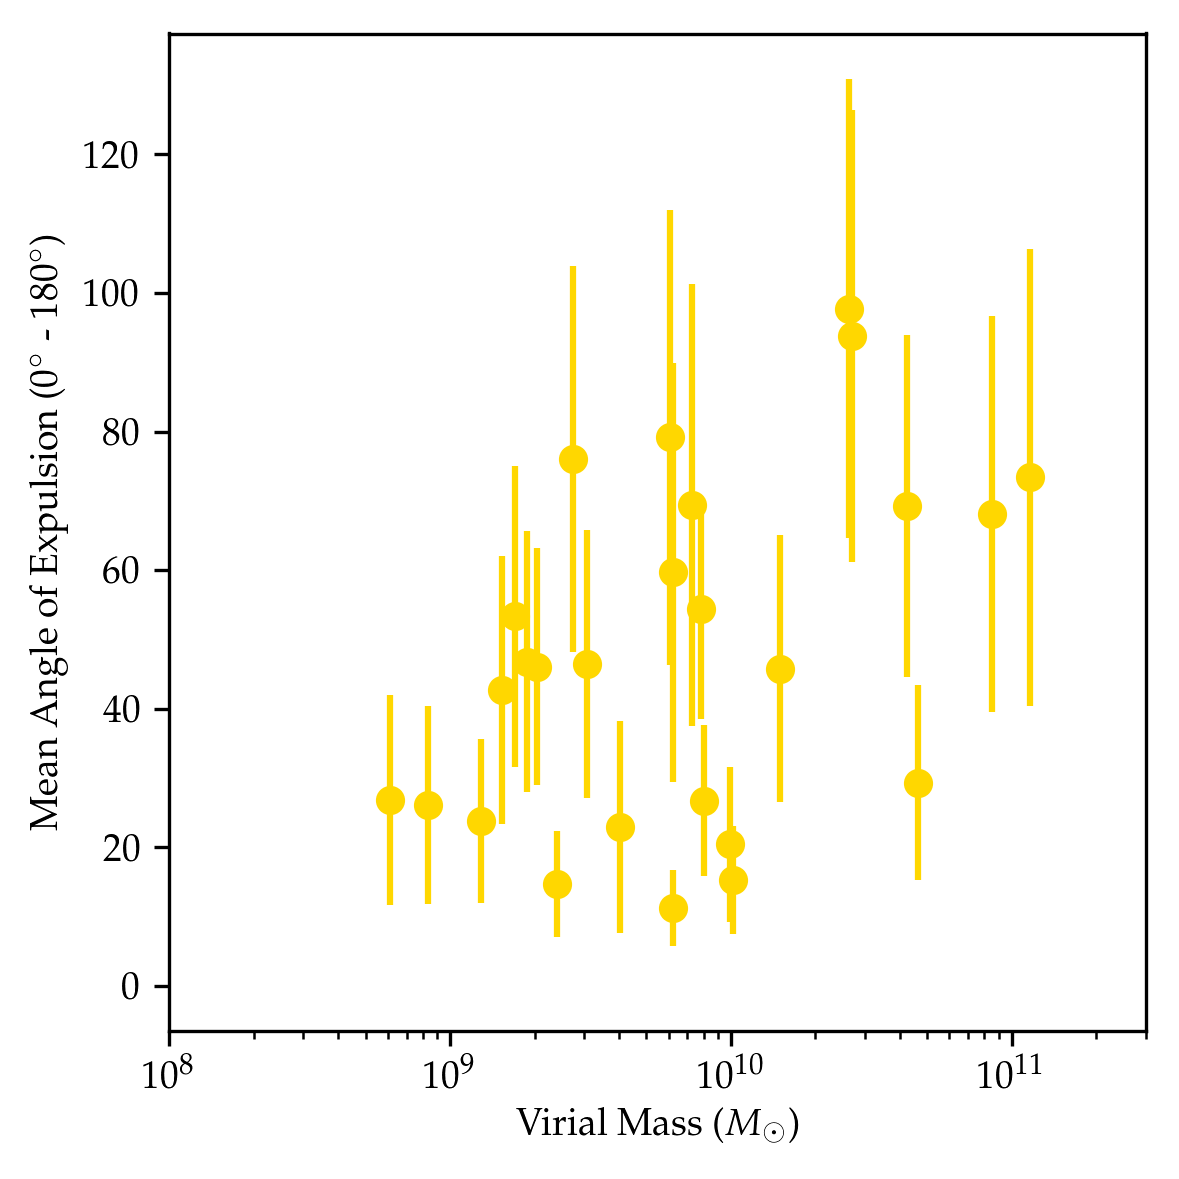

In [37]:
plt.figure(figsize=(4,4), dpi=300)
plt.errorbar(h_mass1, ave_theta1*180/np.pi, yerr=STD1*180/np.pi, linestyle=" ", marker='o', c='gold')#, label='h148')
# plt.errorbar(h_mass2, ave_theta2*180/np.pi, yerr=STD2*180/np.pi, linestyle=" ", marker='^', c='darkgreen', label='h229')
# plt.errorbar(h_mass3, ave_theta3*180/np.pi, yerr=STD3*180/np.pi, linestyle=" ", marker='v', c='limegreen', label='h242')
# plt.errorbar(h_mass4, ave_theta4*180/np.pi, yerr=STD4*180/np.pi, linestyle=" ", marker='D', c='orange', label='h329')
plt.xlim(1e8, 3e11)
plt.semilogx()

#plt.legend(loc='upper left')
plt.xlabel(r'Virial Mass ($M_{\odot}$)')
plt.ylabel('Mean Angle of Expulsion (0$^\circ$ - 180$^\circ$)')
plt.tight_layout()

plt.savefig('Q', dpi=300)
plt.show()

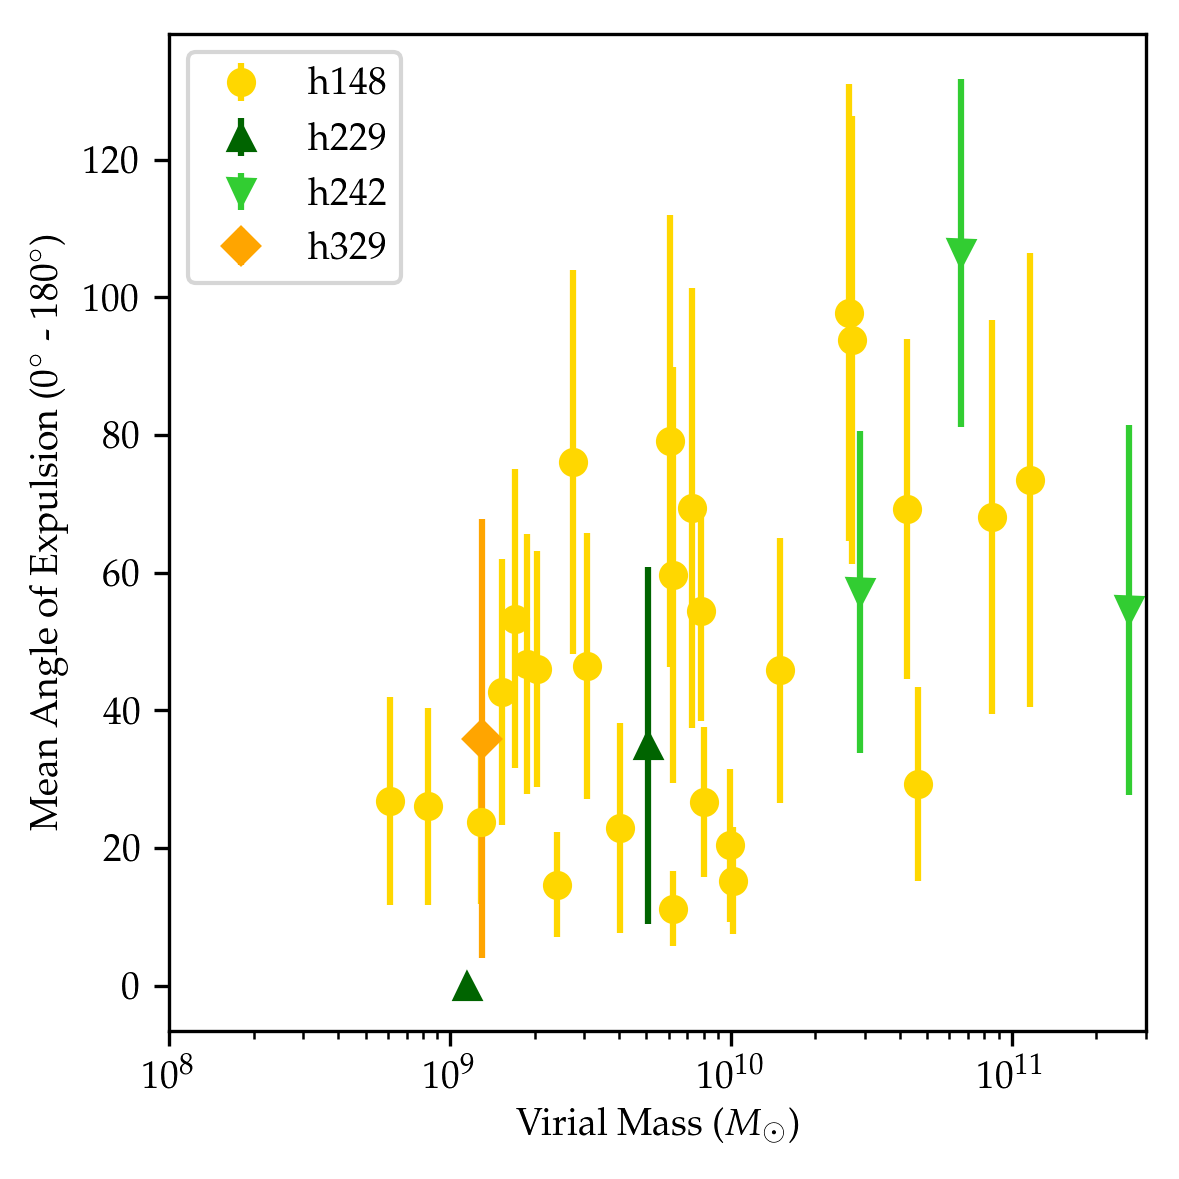

In [27]:
plt.figure(figsize=(4,4), dpi=300)
plt.errorbar(h_mass1, ave_theta1*180/np.pi, yerr=STD1*180/np.pi, linestyle=" ", marker='o', c='gold', label='h148')
plt.errorbar(h_mass2, ave_theta2*180/np.pi, yerr=STD2*180/np.pi, linestyle=" ", marker='^', c='darkgreen', label='h229')
plt.errorbar(h_mass3, ave_theta3*180/np.pi, yerr=STD3*180/np.pi, linestyle=" ", marker='v', c='limegreen', label='h242')
plt.errorbar(h_mass4, ave_theta4*180/np.pi, yerr=STD4*180/np.pi, linestyle=" ", marker='D', c='orange', label='h329')
plt.xlim(1e8, 3e11)
plt.semilogx()

plt.legend(loc='upper left')
plt.xlabel(r'Virial Mass ($M_{\odot}$)')
plt.ylabel('Mean Angle of Expulsion (0$^\circ$ - 180$^\circ$)')
plt.tight_layout()

plt.savefig('Q', dpi=300)
plt.show()

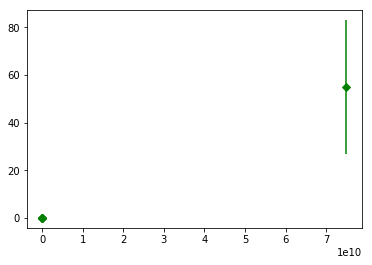

In [84]:
plt.errorbar(h_mass4, ave_theta4*180/np.pi, yerr=STD4*180/np.pi, linestyle=" ", marker='D', c='green')
plt.show()

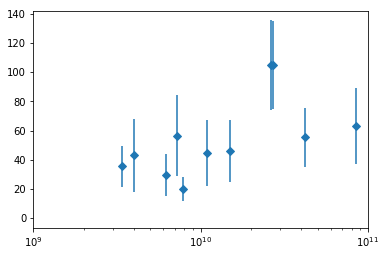

In [20]:
###Vmin = V_escape
plt.errorbar(h_mass1, ave_theta1*180/np.pi, yerr=STD1*180/np.pi, linestyle=" ", marker='D')
plt.errorbar(h_mass2, ave_theta2*180/np.pi, yerr=STD2*180/np.pi, linestyle=" ", marker='D')

plt.xlim(1e9, 1e11)
plt.semilogx()
plt.show()

In [33]:
from Time import *

In [40]:
def deviation(nums): 
    ID = 33
    nums4 = np.array(datat4['haloid'][datat4['z0haloid']==ID])
    timesteps4 = ['h329.cosmo50PLK.3072gst5HbwK1BH.004096', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.004032', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.003936', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.003840', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.003744', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.003648', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.003606', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.003552', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.003456', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.003360', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.003264', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.003195', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.003168', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.003072',
             'h329.cosmo50PLK.3072gst5HbwK1BH.002976', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.002880', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.002784', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.002688', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.002592', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.002554', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.002496', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.002400', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.002304',
             'h329.cosmo50PLK.3072gst5HbwK1BH.002208', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.002112', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.002088', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.002016', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.001920', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.001824',
             'h329.cosmo50PLK.3072gst5HbwK1BH.001740',
             'h329.cosmo50PLK.3072gst5HbwK1BH.001728',
             'h329.cosmo50PLK.3072gst5HbwK1BH.001632', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.001536', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.001475', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.001440', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.001344', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.001269', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.001248',
             'h329.cosmo50PLK.3072gst5HbwK1BH.001152', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.001106', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.001056', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000974', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000960',
             'h329.cosmo50PLK.3072gst5HbwK1BH.000864', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000776', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000768', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000672', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000637', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000576', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000480', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000456', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000384', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000347', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000288', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000275', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000225', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000192', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000188', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000139', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000107', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000096', 
             'h329.cosmo50PLK.3072gst5HbwK1BH.000071']
    timesteps1 = ['.003584','.002816', '.003328', '.003328', '.004096','.002304', '.002304', '.003712', '.003584', '.001920', '.001920', '.003584']
    nums2 = [15, 27, 16, 39, 47, 19]
    timesteps2 = ['.002496', '.002208', '.003264', '.002016', '.002688', '.002304']
    
    h_mass4 = np.zeros(len(nums2))
    STD4 = np.zeros(len(nums2))
    ave_theta4 = np.zeros(len(nums2))
    i = 0
    for num, timestep in zip(nums4, timesteps4):
        print(num,timestep)
        sim_4 ='/home/christenc/Data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/' + timestep
        sim = pynbody.load(sim_4)
        h = sim.halos()
        sim.physical_units()
# ###Loads in halo
        halo_info = sim.halos(dummy=True)
        halo = h.load_copy(num)
        halo.physical_units()
        if len(halo.gas)==0:
            print("No GAS!")
            continue
        pynbody.analysis.halo.center(halo)
        #rvir = halo_info[num].properties['Rvir']/halo_info[num].properties['h']*halo_info[num].properties['a']
        index = np.where(np.array(timesteps4) == timestep)
        print(timestep)
        print(index)
        rvir = (datat4['Rvir'][datat4['z0haloid']==ID].tolist())[int(index[0])]
        print(index[0])
        print(rvir)
        print(halo_info[num].properties['Rvir']/halo_info[num].properties['h']*halo_info[num].properties['a'])
        h_mass4[i] = halo_info[num].properties['mass']
#         ###defines sphere on outer edge of halo
        inner_sphere = pynbody.filt.Sphere(str(.9*rvir) + ' kpc', [0,0,0])
        outer_sphere = pynbody.filt.Sphere(str(rvir) + ' kpc', [0,0,0])
        shell_part = sim[outer_sphere & ~inner_sphere].gas
        if len(shell_part)==0:
            print("No Gas inside")
            continue
#         ###defines sphere surrounding halo
        inner_sphere_wind = pynbody.filt.Sphere(str(rvir) + ' kpc', [0,0,0])
        outer_sphere_wind = pynbody.filt.Sphere(str(3*rvir) + ' kpc', [0,0,0])
        shell_part_wind = sim[outer_sphere_wind & ~inner_sphere_wind].gas
        if len(shell_part_wind)==0:
            print("No Gas outside")
            continue
###Creates cutoff value for vel of gas wind
        windv = (np.sum((shell_part_wind['vel']**2), axis=1))**.5
        vmin = 0.5*halo_info[num].properties['v_esc']
        Wind_mass = np.sum(shell_part_wind['mass'])        
        Wvel = np.array(shell_part_wind['vel'])[windv > vmin]
        Wymass = np.array(shell_part_wind['mass'])[windv > vmin]
        windyvec = np.mean(np.array(Wymass)[np.newaxis].T * Wvel,axis=0)/Wind_mass        
###Find Vel of gas inside the halo and creates array
        velocity = shell_part['vel'].in_units('kpc yr**-1')
        r = shell_part['pos'].in_units('kpc')
        vr = np.sum((velocity*r), axis=1)
        Vout = []
        for x in range(len(vr)):
            if vr[x] > 0:
                vel = list(velocity[x])
                Vout.append(vel)        
    ###takes the magnitude of the gas velocity vectors
        avecs = np.array(Vout)
        amags = (np.sum((avecs**2), axis=1))**.5
        bvec = windyvec
        bmag = (np.sum(bvec**2)**.5)
    ###Finds angle between avec and bvec
        Theta = []
        for avec,amag in zip(avecs,amags):
            adotb = np.sum((avec*bvec))
            ab = amag*bmag
            theta = np.arccos(adotb/ab)
            Theta = np.append(Theta, theta)
        STD4[i] = np.std(Theta)
        ave_theta4[i] = np.mean(Theta)
        i = i + 1
    return h_mass4, ave_theta4, STD4

In [41]:
h_mass4, ave_theta4, STD4 = deviation(1)

33.0 h329.cosmo50PLK.3072gst5HbwK1BH.004096
No GAS!
33.0 h329.cosmo50PLK.3072gst5HbwK1BH.004032
No GAS!
34.0 h329.cosmo50PLK.3072gst5HbwK1BH.003936
No GAS!
34.0 h329.cosmo50PLK.3072gst5HbwK1BH.003840
No GAS!
33.0 h329.cosmo50PLK.3072gst5HbwK1BH.003744
No GAS!
33.0 h329.cosmo50PLK.3072gst5HbwK1BH.003648
No GAS!
33.0 h329.cosmo50PLK.3072gst5HbwK1BH.003606
No GAS!
35.0 h329.cosmo50PLK.3072gst5HbwK1BH.003552
No GAS!
35.0 h329.cosmo50PLK.3072gst5HbwK1BH.003456
No GAS!
34.0 h329.cosmo50PLK.3072gst5HbwK1BH.003360
h329.cosmo50PLK.3072gst5HbwK1BH.003360
(array([9]),)
[9]
33.43
30.185670377599273
No Gas inside
34.0 h329.cosmo50PLK.3072gst5HbwK1BH.003264
h329.cosmo50PLK.3072gst5HbwK1BH.003264
(array([10]),)
[10]
32.56
29.65802175790809
No Gas inside
32.0 h329.cosmo50PLK.3072gst5HbwK1BH.003195
h329.cosmo50PLK.3072gst5HbwK1BH.003195
(array([11]),)
[11]
31.96
29.370976778999566
No Gas inside
32.0 h329.cosmo50PLK.3072gst5HbwK1BH.003168
h329.cosmo50PLK.3072gst5HbwK1BH.003168
(array([12]),)
[12]
31.73


AxisError: axis 1 is out of bounds for array of dimension 1